In [45]:
#Import necessary Librarires
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

In [10]:
df = pd.read_csv("train_augment_dataset.csv")
df = df.drop(columns=["Unnamed: 0"])
df

,id,score,num_comments,created_utc,clean_text,sentiment,polarity,subjectivity,label
0,1faqbtw,164,165,2024-09-06 21:18:45,filed fcc complaint,neg,-0.300000,0.200000,non-churn
1,192igbt,141,122,2024-01-09 16:19:40,why verizon support excruciatingingly useless,neg,-0.500000,0.200000,non-churn
2,1cmh1b8,110,382,2024-05-07 17:09:53,verizon losing customer,neu,0.000000,0.000000,non-churn
3,1867s7a,82,186,2023-11-28 21:47:54,verizon accidentally sent iphone pro max,neu,0.000000,0.000000,non-churn
4,hnmb6q,84,83,2020-07-08 18:19:48,verizon fallen last place network speed,neu,0.000000,0.066667,non-churn
...,...,...,...,...,...,...,...,...,...
593,s4an9a,60,37,2022-01-15 03:27:09,found live band site going freeway chandler.co...,pos,0.136364,0.500000,non-churn
594,18k27z2,125,136,2023-12-16 22:22:08,massive verizon outage georgia.com/news/local/...,neu,0.000000,1.000000,non-churn
595,18k27z2,125,136,2023-12-16 22:22:08,massive verizon outage georgia.com/news/local/...,neu,0.000000,1.000000,non-churn
596,11ptzzv,113,24,2023-03-12 23:51:09,appreciation verizon.com/\n\nThe following is ...,neu,0.000000,0.000000,churn


In [14]:
#lets label the churn as churn_likeliness where, churn = 0 and churn = 1

df['churn_likeliness'] = df['label'].map({'churn': 1, 'non-churn': 0})
df = df.drop(columns= ['label'])
df['sentiment'] = df['sentiment'].map({'neg': -1, 'neu': 0, 'pos': 1})

NOW WE HAVE OUR FEATURES:
1. Score
2. Number of Comments
3. Sentiment 
4. Polarity
5. Subjectivity 
6. Date - When it comes to Time Series, this will come handy

TARGET TO PREDICT:
CHURN --- WHETHER A CUSTOMER WILL LEAVE OR NOT ?



In [18]:
df['Date'] = pd.to_datetime(df['created_utc'])

In [21]:
#Feature Selection:
#A. Correlation:
columns = ['score','num_comments','Date','sentiment','polarity','subjectivity', 'churn_likeliness']
df_features = df[columns]

In [22]:
df_features

,score,num_comments,Date,sentiment,polarity,subjectivity,churn_likeliness
0,164,165,2024-09-06 21:18:45,-1,-0.300000,0.200000,0
1,141,122,2024-01-09 16:19:40,-1,-0.500000,0.200000,0
2,110,382,2024-05-07 17:09:53,0,0.000000,0.000000,0
3,82,186,2023-11-28 21:47:54,0,0.000000,0.000000,0
4,84,83,2020-07-08 18:19:48,0,0.000000,0.066667,0
...,...,...,...,...,...,...,...
593,60,37,2022-01-15 03:27:09,1,0.136364,0.500000,0
594,125,136,2023-12-16 22:22:08,0,0.000000,1.000000,0
595,125,136,2023-12-16 22:22:08,0,0.000000,1.000000,0
596,113,24,2023-03-12 23:51:09,0,0.000000,0.000000,1


/var/folders/rk/qbqh0zk94fb809xskjyt0zt00000gn/T/ipykernel_5217/185045786.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_features.corr()


Top correlated features with churn_likeliness:
churn_likeliness    1.000000
polarity            0.273007
sentiment           0.262339
subjectivity        0.111788
score              -0.060597
num_comments       -0.165439
Name: churn_likeliness, dtype: float64


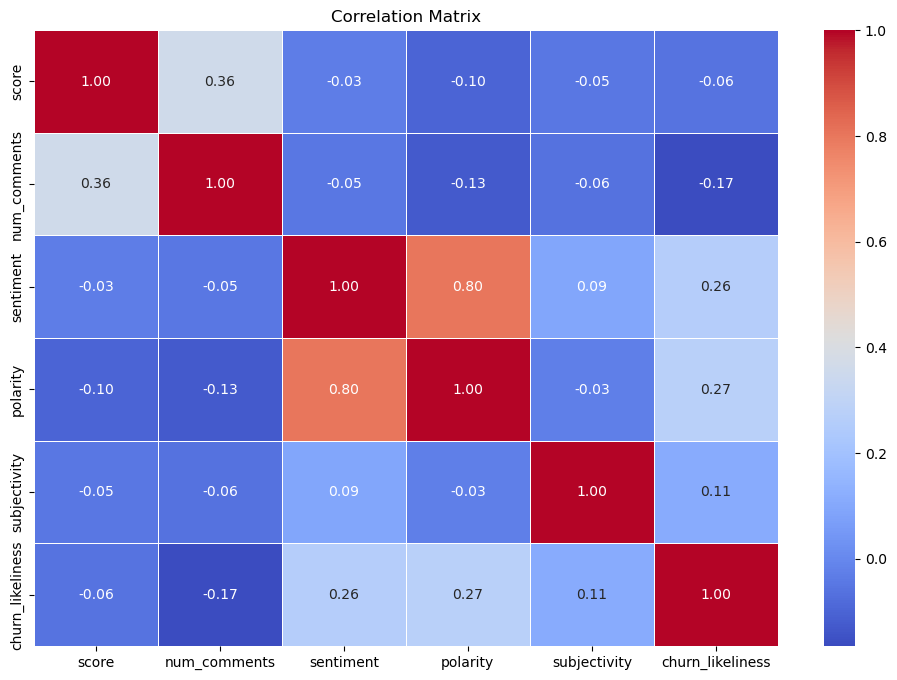

In [28]:
# Calculate the correlation matrix
corr_matrix = df_features.corr()

# Isolate the correlation with the target variable (churn_likeliness)
corr_target = corr_matrix['churn_likeliness'].sort_values(ascending=False)

# Display the top correlated features with churn_likeliness
print("Top correlated features with churn_likeliness:")
print(corr_target)

# Visualize the correlation matrix (optional)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Not much of a correlation we have here, only Sentiment and Polarity is correlated with our target.

In [38]:
df_step_wise = df_features.drop(['Date'], axis=1, errors='ignore')


In [41]:
#Step wise feature selection:

X = df_step_wise.drop('churn_likeliness', axis=1)  # Features (excluding the target)
y = df_step_wise['churn_likeliness']  # Target variable


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model (you can use any other model like RandomForest, etc.)
model = LogisticRegression()

# Perform forward feature selection
sfs = SFS(model, 
          k_features='best',  # 'best' to find the optimal number of features
          forward=True, 
          floating=False, 
          scoring='accuracy',  # You can change to 'r2' for regression problems
          cv=5)  # Cross-validation

# Fit the feature selector
sfs.fit(X_train, y_train)

# Selected features
selected_features = list(sfs.k_feature_names_)
print(f"Selected features: {selected_features}")


Selected features: ['score', 'num_comments', 'polarity', 'subjectivity']


/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
import statsmodels.api as sm

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit an OLS model (Ordinary Least Squares)
model = sm.OLS(y, X).fit()

# Print a summary of the model
print(model.summary())

# Eliminate features with p-value > 0.05 (you can adjust the threshold)
while True:
    p_values = model.pvalues
    max_p_value = p_values.max()  # Find max p-value
    if max_p_value > 0.05:  # Threshold for feature elimination
        max_p_feature = p_values.idxmax()  # Feature with highest p-value
        X = X.drop(max_p_feature, axis=1)  # Drop the feature
        model = sm.OLS(y, X).fit()  # Refit the model
    else:
        break

# Final selected features
print(f"Selected features after backward elimination: {X.columns.tolist()}")


                            OLS Regression Results                            
Dep. Variable:       churn_likeliness   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     14.40
Date:                Mon, 16 Sep 2024   Prob (F-statistic):           2.50e-13
Time:                        19:15:48   Log-Likelihood:                -377.49
No. Observations:                 598   AIC:                             767.0
Df Residuals:                     592   BIC:                             793.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3946      0.043      9.122   

In [44]:

X = df_features[['num_comments', 'polarity', 'subjectivity','score','sentiment']]
vif = pd.DataFrame()
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


       features       VIF
0  num_comments  2.765854
1      polarity  2.899515
2  subjectivity  1.425913
3         score  2.924141
4     sentiment  2.952376


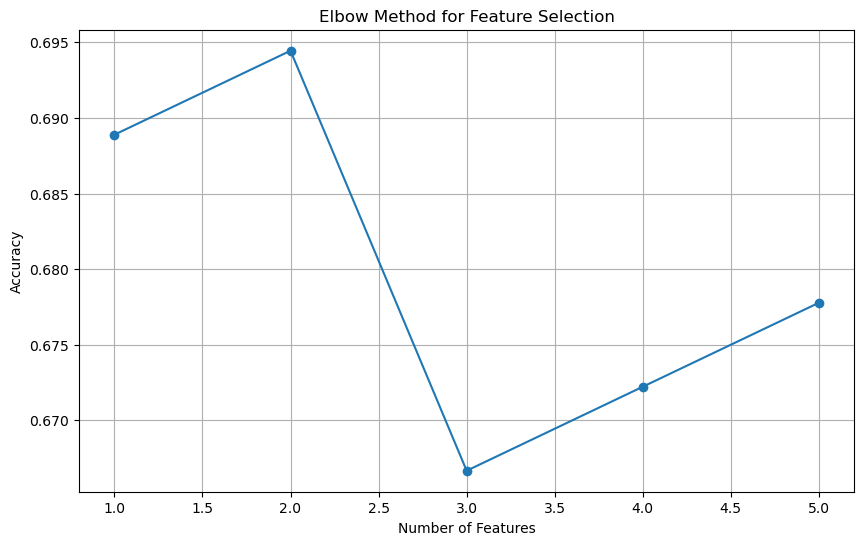

In [46]:
#Elbow method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize lists to store results
num_features = []
accuracies = []

# Fit RFE with varying number of features
for n in range(1, X_train.shape[1] + 1):
    model = LogisticRegression(max_iter=1000)
    rfe = RFE(model, n_features_to_select=n)
    rfe = rfe.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rfe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Record the number of features and accuracy
    num_features.append(n)
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_features, accuracies, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Elbow Method for Feature Selection')
plt.grid(True)
plt.show()

FROM THE RESULTS OF DIFFERENT FEATURE SELECTION METHODS: OPTIMAL TO CHOOSE: 'num_comments', 'polarity', 'subjectivity' to predict whether churn is 0 or 1. This is a numerical way to do this, lets model it the same way. 

In [114]:
X = df_features[['num_comments', 'polarity', 'subjectivity']]
y = df_features['churn_likeliness']

In [115]:
X

,num_comments,polarity,subjectivity
0,165,-0.300000,0.200000
1,122,-0.500000,0.200000
2,382,0.000000,0.000000
3,186,0.000000,0.000000
4,83,0.000000,0.066667
...,...,...,...
593,37,0.136364,0.500000
594,136,0.000000,1.000000
595,136,0.000000,1.000000
596,24,0.000000,0.000000


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [90]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [91]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)


DecisionTreeClassifier()

In [69]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [92]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [93]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)


SVC()

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5994 - loss: 2.3325
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6500 - loss: 0.8670
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5470 - loss: 0.7643
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6180 - loss: 0.6977
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6473 - loss: 0.7624
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4371 - loss: 0.7318
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5161 - loss: 0.8000
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5726 - loss: 0.6998
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6585 - loss: 0.6933
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4831 - loss: 0.6873


In [96]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)


GaussianNB()

In [97]:
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = GaussianNB()

ensemble_model = VotingClassifier(estimators=[
    ('lr', model1),
    ('rf', model2),
    ('gb', model3)
], voting='soft')

ensemble_model.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('gb', GaussianNB())],
                 voting='soft')

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Example data
# X and y should be your features and target variable
X = df_step_wise.drop('churn_likeliness', axis=1)  # Drop the target column
y = df_step_wise['churn_likeliness']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)  # SVM needs probability=True for ROC curve
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)


In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    metrics = {
        'Accuracy': [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)],
        'Precision': [precision_score(y_train, y_pred_train), precision_score(y_test, y_pred_test)],
        'Recall': [recall_score(y_train, y_pred_train), recall_score(y_test, y_pred_test)],
        'F1 Score': [f1_score(y_train, y_pred_train), f1_score(y_test, y_pred_test)],
        'AUC': [roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]), roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])]
    }
    
    return metrics

# Store results
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

import pandas as pd
results_df = pd.DataFrame(results).transpose()
print(results_df)


                                                     Accuracy  \
Logistic Regression               [0.6652719665271967, 0.675]   
Decision Tree        [0.9288702928870293, 0.7666666666666667]   
Random Forest                      [0.9288702928870293, 0.75]   
SVM                               [0.6485355648535565, 0.625]   

                                                    Precision  \
Logistic Regression  [0.5714285714285714, 0.6071428571428571]   
Decision Tree                    [0.9375, 0.7575757575757576]   
Random Forest        [0.9166666666666666, 0.7027027027027027]   
SVM                                                [1.0, 0.0]   

                                                        Recall  \
Logistic Regression  [0.3218390804597701, 0.37777777777777777]   
Decision Tree         [0.8620689655172413, 0.5555555555555556]   
Random Forest         [0.8850574712643678, 0.5777777777777777]   
SVM                                [0.034482758620689655, 0.0]   

                 

/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
results_df

,Accuracy,Precision,Recall,F1 Score,AUC
Logistic Regression,"[0.6652719665271967, 0.675]","[0.5714285714285714, 0.6071428571428571]","[0.3218390804597701, 0.37777777777777777]","[0.4117647058823529, 0.4657534246575342]","[0.7018772686025407, 0.6666666666666666]"
Decision Tree,"[0.9288702928870293, 0.7666666666666667]","[0.9375, 0.7575757575757576]","[0.8620689655172413, 0.5555555555555556]","[0.8982035928143712, 0.6410256410256411]","[0.9869838929219601, 0.7632592592592593]"
Random Forest,"[0.9288702928870293, 0.75]","[0.9166666666666666, 0.7027027027027027]","[0.8850574712643678, 0.5777777777777777]","[0.9005847953216374, 0.6341463414634145]","[0.9869271778584392, 0.8112592592592593]"
SVM,"[0.6485355648535565, 0.625]","[1.0, 0.0]","[0.034482758620689655, 0.0]","[0.06666666666666667, 0.0]","[0.6847115093768905, 0.5466666666666667]"


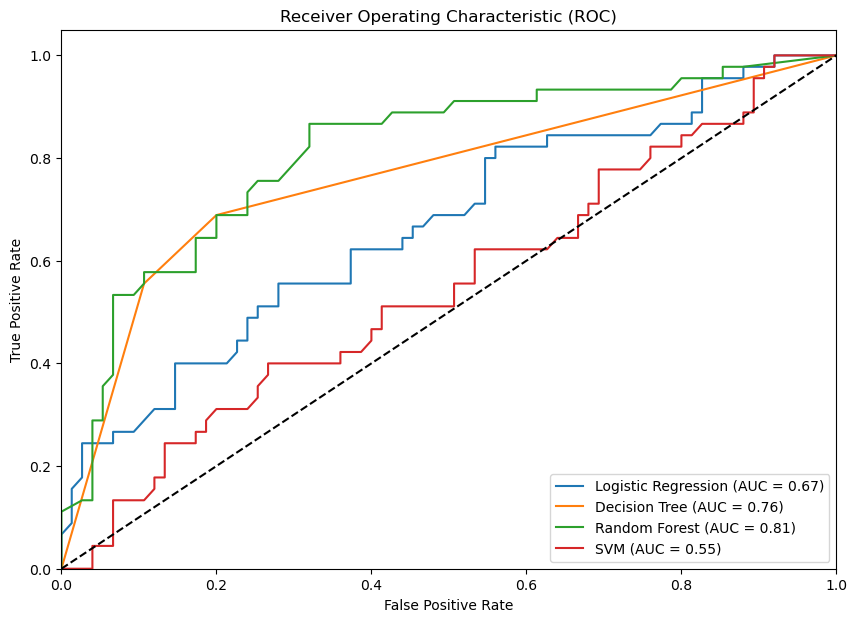

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test, label):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 7))
for name, model in models.items():
    plot_roc_curve(model, X_test, y_test, name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


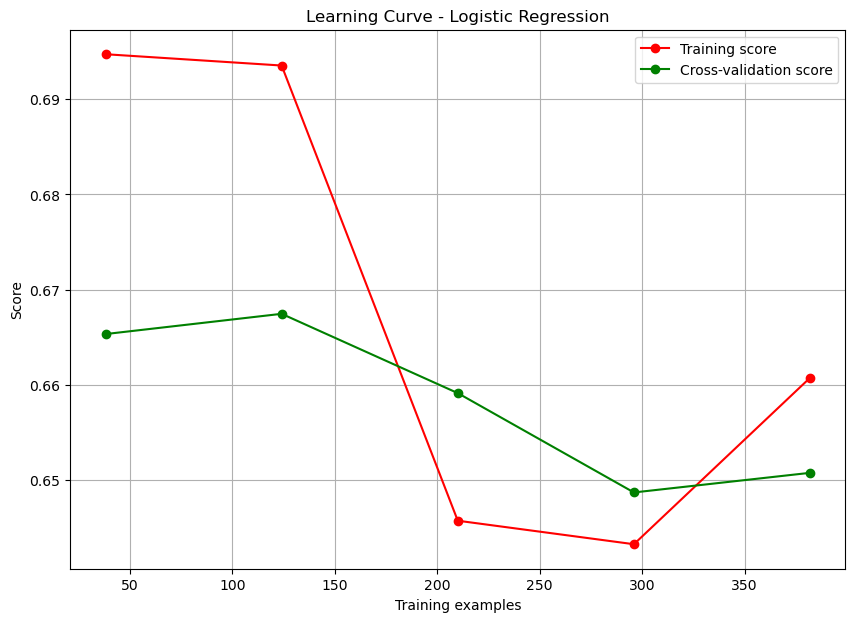

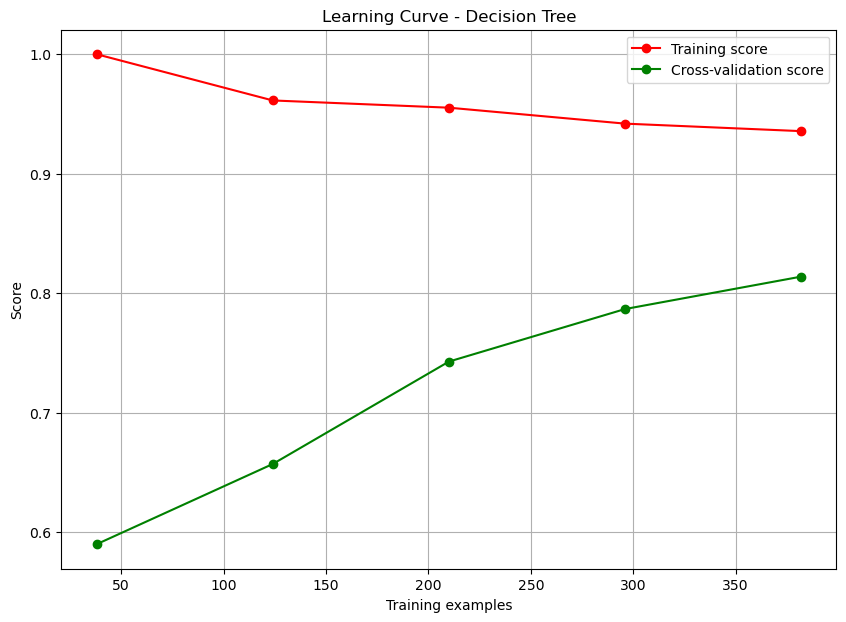

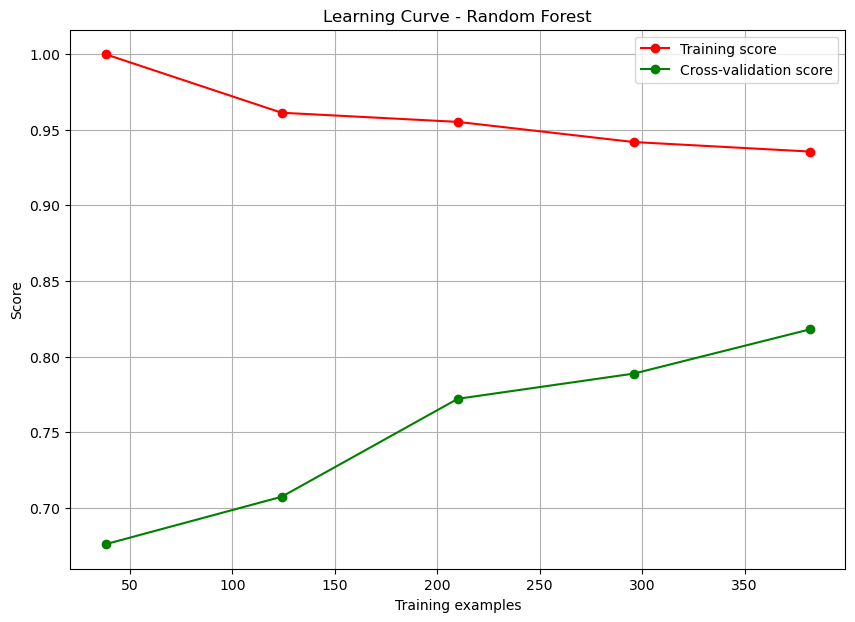

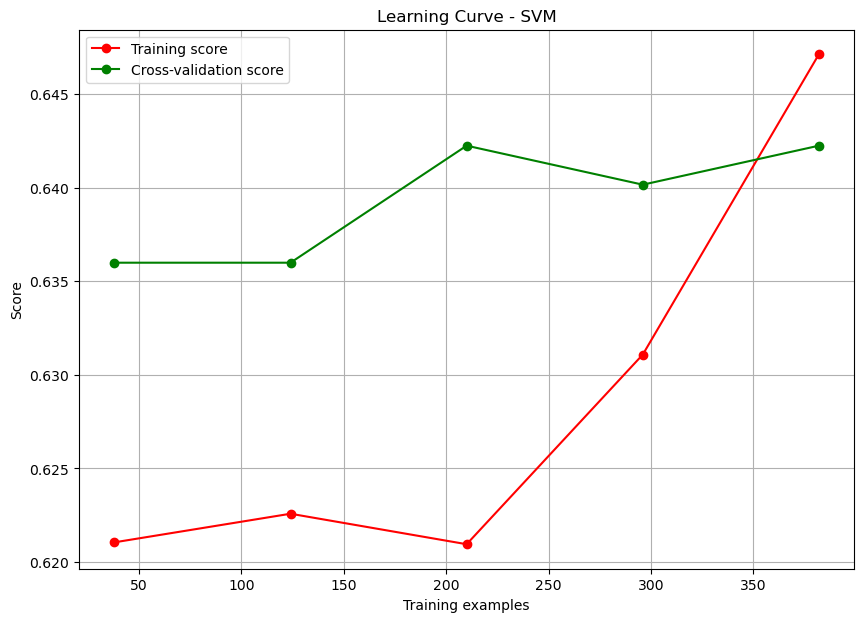

In [102]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    
    plt.figure(figsize=(10, 7))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot learning curves for each model
for name, model in models.items():
    plot_learning_curve(model, X_train, y_train, f'Learning Curve - {name}')


In [147]:
#Random Forest looks fine, so lets proceed with RF, DT and Deep Learning:
df_predict = pd.read_csv('remaining_data.csv')
df_predict = df_predict[['id','polarity','subjectivity','num_comments']]

In [148]:
X_train_reduced = df_features[['polarity', 'subjectivity', 'num_comments']]  # Train with these columns
y_train = df_features['churn_likeliness'] 
# Retrain the model
from sklearn.ensemble import RandomForestClassifier
model_retrained = RandomForestClassifier()
model_retrained.fit(X_train_reduced, y_train)

# Predict churn on df_predict using the retrained model
X_predict = df_predict[['polarity', 'subjectivity', 'num_comments']]  # Match the same features

# Make predictions
df_predict['churn_likeliness'] = model_retrained.predict(X_predict)

# Get probabilities if needed
df_predict['churn_probability'] = model_retrained.predict_proba(X_predict)[:, 1]


In [149]:
df_predict

,id,polarity,subjectivity,num_comments,churn_likeliness,churn_probability
0,19fdi1v,0.000,0.000,587,0,0.000000
1,1f942vd,0.000,0.000,593,0,0.000000
2,1atncm6,0.000,0.000,268,0,0.010000
3,1cd3l8i,0.000,0.000,409,0,0.000000
4,1fdqa2o,0.000,0.000,292,0,0.000000
...,...,...,...,...,...,...
469,nrg7ax,0.000,0.000,16,1,0.500248
470,lcsg80,0.000,0.000,84,0,0.023500
471,jbukpk,0.000,1.000,77,1,0.674333
472,i94qtf,0.375,0.475,42,0,0.251000


In [136]:
X_train_reduced = df_features[['polarity', 'subjectivity', 'num_comments']]  # Train with these columns
y_train = df_features['churn_likeliness'] 

model_retrained = DecisionTreeClassifier()
model_retrained.fit(X_train_reduced, y_train)

# Predict churn on df_predict using the retrained model
X_predict = df_predict[['polarity', 'subjectivity', 'num_comments']]  # Match the same features

# Make predictions
df_predict['churn_likeliness'] = model_retrained.predict(X_predict)

# Get probabilities if needed
df_predict['churn_probability'] = model_retrained.predict_proba(X_predict)[:, 1]

In [128]:
# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_reduced.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reduced, y_train, epochs=10, batch_size=32)

# Predict on df_predict
X_predict = df_predict[['polarity', 'subjectivity', 'num_comments']]  # Ensure these are the same features used in training
df_predict['churn_likeliness'] = model.predict(X_predict)

# If you want to see the probability output (optional)
df_predict['churn_probability'] = model.predict(X_predict)


Epoch 1/10


/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5965 - loss: 3.2325
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6366 - loss: 0.7305
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6140 - loss: 0.6631
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6588 - loss: 0.6532
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6840 - loss: 0.6381
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6623 - loss: 0.6546
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6324 - loss: 0.6665
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6461 - loss: 0.6533
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6679 - loss: 0.6685
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6575 - loss: 0.6574
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [129]:
df_predict

,id,polarity,subjectivity,num_comments,churn_likeliness,churn_probability
0,19fdi1v,0.000,0.000,587,0.003724,0.003724
1,1f942vd,0.000,0.000,593,0.003516,0.003516
2,1atncm6,0.000,0.000,268,0.073774,0.073774
3,1cd3l8i,0.000,0.000,409,0.020188,0.020188
4,1fdqa2o,0.000,0.000,292,0.059510,0.059510
...,...,...,...,...,...,...
469,nrg7ax,0.000,0.000,16,0.471662,0.471662
470,lcsg80,0.000,0.000,84,0.317436,0.317436
471,jbukpk,0.000,1.000,77,0.368014,0.368014
472,i94qtf,0.375,0.475,42,0.453594,0.453594


In [133]:
df_predict = pd.read_csv('remaining_data.csv')
df_predict

,id,title,score,url,num_comments,created_utc,clean_text,hashtags,sentiment,polarity,subjectivity
0,19fdi1v,Verizon raising rates again,457,https://www.reddit.com/r/verizon/comments/19fd...,587,2024-01-25 16:39:15,verizon raising rate,{},neu,0.000,0.000
1,1f942vd,Verizon lowering autopay discount for customer...,362,https://www.reddit.com/r/verizon/comments/1f94...,593,2024-09-04 20:42:05,verizon lowering autopay discount customer myplan,{},neu,0.000,0.000
2,1atncm6,Verizon employee text me after I paid my phone...,364,https://www.reddit.com/r/verizon/comments/1atn...,268,2024-02-18 06:15:04,verizon employee text paid phone bill,{},neu,0.000,0.000
3,1cd3l8i,Verizon watch plan increase $5,360,https://www.reddit.com/r/verizon/comments/1cd3...,409,2024-04-25 21:37:58,verizon watch plan increase,{},neu,0.000,0.000
4,1fdqa2o,LPT: You don’t have to pay the $35 “F—k you” u...,351,https://www.reddit.com/r/verizon/comments/1fdq...,292,2024-09-10 19:17:15,lpt you pay upgrade fee,{},neu,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
469,nrg7ax,Scam Alert,60,https://www.reddit.com/r/verizon/comments/nrg7...,16,2021-06-03 15:29:13,scam alert,{},neu,0.000,0.000
470,lcsg80,I got a phone for my friend of two years in my...,57,https://www.reddit.com/r/verizon/comments/lcsg...,84,2021-02-04 22:45:35,got phone friend two year name paying died car...,{},neu,0.000,0.000
471,jbukpk,The (Almost) Ultimate Buying Guide For iPhone ...,56,https://www.reddit.com/r/verizon/comments/jbuk...,77,2020-10-15 19:35:08,the almost ultimate buying guide for iphone tr...,{},neu,0.000,1.000
472,i94qtf,Today's call to CS is making me miss all of th...,55,https://www.reddit.com/r/verizon/comments/i94q...,42,2020-08-13 17:56:50,call making miss really good agent apparently ...,{},pos,0.375,0.475


Now that we have satisfied results from non-NLP or rather traditional methods, lets move this to the next set of modelling a.k.a NLP based methods.

In [150]:
df = pd.read_csv("train_augment_dataset.csv")
df = df.drop(columns=["Unnamed: 0"])
df

,id,score,num_comments,created_utc,clean_text,sentiment,polarity,subjectivity,label
0,1faqbtw,164,165,2024-09-06 21:18:45,filed fcc complaint,neg,-0.300000,0.200000,non-churn
1,192igbt,141,122,2024-01-09 16:19:40,why verizon support excruciatingingly useless,neg,-0.500000,0.200000,non-churn
2,1cmh1b8,110,382,2024-05-07 17:09:53,verizon losing customer,neu,0.000000,0.000000,non-churn
3,1867s7a,82,186,2023-11-28 21:47:54,verizon accidentally sent iphone pro max,neu,0.000000,0.000000,non-churn
4,hnmb6q,84,83,2020-07-08 18:19:48,verizon fallen last place network speed,neu,0.000000,0.066667,non-churn
...,...,...,...,...,...,...,...,...,...
593,s4an9a,60,37,2022-01-15 03:27:09,found live band site going freeway chandler.co...,pos,0.136364,0.500000,non-churn
594,18k27z2,125,136,2023-12-16 22:22:08,massive verizon outage georgia.com/news/local/...,neu,0.000000,1.000000,non-churn
595,18k27z2,125,136,2023-12-16 22:22:08,massive verizon outage georgia.com/news/local/...,neu,0.000000,1.000000,non-churn
596,11ptzzv,113,24,2023-03-12 23:51:09,appreciation verizon.com/\n\nThe following is ...,neu,0.000000,0.000000,churn


In [151]:
df['churn_likeliness'] = df['label'].map({'churn': 1, 'non-churn': 0})
df = df.drop(columns= ['label'])
df

,id,score,num_comments,created_utc,clean_text,sentiment,polarity,subjectivity,churn_likeliness
0,1faqbtw,164,165,2024-09-06 21:18:45,filed fcc complaint,neg,-0.300000,0.200000,0
1,192igbt,141,122,2024-01-09 16:19:40,why verizon support excruciatingingly useless,neg,-0.500000,0.200000,0
2,1cmh1b8,110,382,2024-05-07 17:09:53,verizon losing customer,neu,0.000000,0.000000,0
3,1867s7a,82,186,2023-11-28 21:47:54,verizon accidentally sent iphone pro max,neu,0.000000,0.000000,0
4,hnmb6q,84,83,2020-07-08 18:19:48,verizon fallen last place network speed,neu,0.000000,0.066667,0
...,...,...,...,...,...,...,...,...,...
593,s4an9a,60,37,2022-01-15 03:27:09,found live band site going freeway chandler.co...,pos,0.136364,0.500000,0
594,18k27z2,125,136,2023-12-16 22:22:08,massive verizon outage georgia.com/news/local/...,neu,0.000000,1.000000,0
595,18k27z2,125,136,2023-12-16 22:22:08,massive verizon outage georgia.com/news/local/...,neu,0.000000,1.000000,0
596,11ptzzv,113,24,2023-03-12 23:51:09,appreciation verizon.com/\n\nThe following is ...,neu,0.000000,0.000000,1


In [152]:
df['churn_likeliness'].value_counts()

0    379
1    219
Name: churn_likeliness, dtype: int64

In [156]:
import time
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

start_time = time.time()                                    
clean_text = []

# Iterate through each value in the 'clean_text' column
for text in df['clean_text']:
    if isinstance(text, str):  # Check if the value is a string
        words = regexp_tokenize(text.lower(), r'[A-Za-z]+')
        words = [w for w in words if len(w) > 1 and w not in stopwords.words('english')]
        words = [lemmatizer.lemmatize(w) for w in words]
        clean_text.append(' '.join(words))
    else:
        clean_text.append('')  # If not a string, append an empty string

print('Elapsed clock time: ', (time.time() - start_time)/60, ' minutes')

# Update the 'clean_text' column with the cleaned data
df['clean_text'] = clean_text



Elapsed clock time:  0.028560781478881837  minutes


,id,score,num_comments,created_utc,clean_text,sentiment,polarity,subjectivity,churn_likeliness
0,1faqbtw,164,165,2024-09-06 21:18:45,filed fcc complaint,neg,-0.3,0.200000,0
1,192igbt,141,122,2024-01-09 16:19:40,verizon support excruciatingingly useless,neg,-0.5,0.200000,0
2,1cmh1b8,110,382,2024-05-07 17:09:53,verizon losing customer,neu,0.0,0.000000,0
3,1867s7a,82,186,2023-11-28 21:47:54,verizon accidentally sent iphone pro max,neu,0.0,0.000000,0
4,hnmb6q,84,83,2020-07-08 18:19:48,verizon fallen last place network speed,neu,0.0,0.066667,0


In [159]:

# Split data into train and validation and encode label
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_x, valid_x, train_y, valid_y = train_test_split(df['clean_text'], df['churn_likeliness'], test_size=0.2, random_state=45)

In [161]:
#Converting the x value to numeric
#Text vectorization: Create count, TF-IDF, and n-gram vectorizers

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# n-gram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5), max_features=5000)
tfidf_vect_ngram.fit(df['clean_text'])
xtrain_tfidf_ngram = tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram = tfidf_vect_ngram.transform(valid_x)

In [162]:
# Classification Models and Success metrics
  
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
  
def model(classifier, train_vector, valid_vector):
    classifier.fit(train_vector, train_y)  
    predict_y = classifier.predict(valid_vector)
    accuracy = accuracy_score(valid_y, predict_y)
    precision = precision_score(valid_y, predict_y,labels=[0,1,2,3,4,5,6],average=None)
    recall = recall_score(valid_y, predict_y,labels=[0,1,2,3,4,5,6],average=None)
    conf_matrix = confusion_matrix(valid_y, classifier.predict(valid_vector))
    print('\nAccuracy_score: {:.3f}'.format(accuracy ))
    print('precision_score: {:.3f}'.format(precision.mean()))
    print('recall_score: {:.3f}'.format(recall.mean()))
    print('\nconfusion_matrix: \n')
    
    print(confusion_matrix(valid_y, classifier.predict(valid_vector)))
   
    return 

In [163]:
from sklearn.naive_bayes import MultinomialNB
model(MultinomialNB(), xtrain_tfidf_ngram, xvalid_tfidf_ngram)


Accuracy_score: 0.833
precision_score: 0.242
recall_score: 0.225

confusion_matrix: 

[[73  4]
 [16 27]]


/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [164]:
from xgboost import XGBClassifier
model(XGBClassifier(), xtrain_tfidf_ngram.tocsc(), xvalid_tfidf_ngram.tocsc())


Accuracy_score: 0.833
precision_score: 0.236
recall_score: 0.230

confusion_matrix: 

[[70  7]
 [13 30]]


/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [165]:
m=XGBClassifier()

In [166]:
m.fit(xtrain_tfidf_ngram,train_y)
predict_y = m.predict(xvalid_tfidf_ngram)
predict_y

array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0])

In [167]:
valid_y

546    1
4      0
63     0
472    0
259    0
      ..
332    1
487    0
221    1
239    0
370    0
Name: churn_likeliness, Length: 120, dtype: int64

In [168]:

df.iloc[330]

id                                                             irjd5v
score                                                              73
num_comments                                                       17
created_utc                                       2020-09-12 19:47:32
clean_text          asbury park arrested suspicion assault battery...
sentiment                                                         neu
polarity                                                          0.0
subjectivity                                                      0.0
churn_likeliness                                                    0
Name: 330, dtype: object

In [185]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Convert text to BoW features
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_bow = vectorizer.fit_transform(df['clean_text'])

# Combine with other features
import numpy as np
X_other = df[['score', 'num_comments', 'polarity', 'subjectivity']].values
X = np.hstack((X_bow.toarray(), X_other))

y = df['churn_likeliness']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
LR_model_1 = LogisticRegression(max_iter=1000)
LR_model_1.fit(X_train, y_train)

# Evaluate
y_pred = LR_model_1.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.95      0.88        75
           1       0.88      0.67      0.76        45

    accuracy                           0.84       120
   macro avg       0.85      0.81      0.82       120
weighted avg       0.85      0.84      0.84       120



In [186]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df['clean_text'])


X_other = df[['score', 'num_comments', 'polarity', 'subjectivity']].values
X = np.hstack((X_tfidf.toarray(), X_other))

y = df['churn_likeliness']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
LR_model_2 = LogisticRegression(max_iter=1000)
LR_model_2.fit(X_train, y_train)

# Evaluate
y_pred = LR_model_2.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.92      0.81        75
           1       0.75      0.40      0.52        45

    accuracy                           0.73       120
   macro avg       0.73      0.66      0.66       120
weighted avg       0.73      0.72      0.70       120



In [187]:
import gensim
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Example using Gensim's Word2Vec
tokenized_text = df['clean_text'].apply(lambda x: x.split())
model_w2v = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# Function to average word vectors
def get_avg_vector(text):
    words = text.split()
    vectors = [model_w2v.wv[word] for word in words if word in model_w2v.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_embeddings = np.vstack(df['clean_text'].apply(get_avg_vector))

# Combine with other features and proceed
X_other = df[['score', 'num_comments', 'polarity', 'subjectivity']].values
X = np.hstack((X_embeddings, X_other))  # Remove .toarray()

y = df['churn_likeliness']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
LR_model_3 = LogisticRegression(max_iter=1000)
LR_model_3.fit(X_train, y_train)

# Evaluate
y_pred = LR_model_3.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.69      0.91      0.78        75
           1       0.67      0.31      0.42        45

    accuracy                           0.68       120
   macro avg       0.68      0.61      0.60       120
weighted avg       0.68      0.68      0.65       120



In [188]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

tagged_docs = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(df['clean_text'])]
model_d2v = Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=1, workers=4)

X_doc2vec = np.vstack([model_d2v.infer_vector(doc.split()) for doc in df['clean_text']])

X_other = df[['score', 'num_comments', 'polarity', 'subjectivity']].values
X = np.hstack((X_doc2vec, X_other)) 

y = df['churn_likeliness']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
LR_model_4 = LogisticRegression(max_iter=1000)
LR_model_4.fit(X_train, y_train)

# Evaluate
y_pred = LR_model_4.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.89      0.78        75
           1       0.67      0.36      0.46        45

    accuracy                           0.69       120
   macro avg       0.68      0.62      0.62       120
weighted avg       0.69      0.69      0.66       120



In [189]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X_seq = pad_sequences(sequences, maxlen=100)

# Define CNN model
CNN_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
CNN_model.fit(X_seq, y, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5


/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.6356 - loss: 0.6604 - val_accuracy: 0.6333 - val_loss: 0.6465
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6427 - loss: 0.5742 - val_accuracy: 0.6333 - val_loss: 0.6280
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7344 - loss: 0.4508 - val_accuracy: 0.6500 - val_loss: 0.6025
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9664 - loss: 0.2676 - val_accuracy: 0.6833 - val_loss: 0.6627
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9939 - loss: 0.1020 - val_accuracy: 0.6667 - val_loss: 0.8096


In [190]:
from tensorflow.keras.layers import LSTM

LSTM_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_model.fit(X_seq, y, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 234s 15s/step - accuracy: 0.6423 - loss: 0.6833 - val_accuracy: 0.6333 - val_loss: 0.6527
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 222s 15s/step - accuracy: 0.6463 - loss: 0.6208 - val_accuracy: 0.6500 - val_loss: 0.6252
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 223s 15s/step - accuracy: 0.7535 - loss: 0.4670 - val_accuracy: 0.7167 - val_loss: 0.6831
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 222s 15s/step - accuracy: 0.9014 - loss: 0.2830 - val_accuracy: 0.7167 - val_loss: 0.9121
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 222s 15s/step - accuracy: 0.9276 - loss: 0.1735 - val_accuracy: 0.7167 - val_loss: 1.2566


In [184]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Tokenize texts
inputs = tokenizer(df['clean_text'].tolist(), return_tensors='tf', padding=True, truncation=True, max_length=128)
labels = tf.convert_to_tensor(y)

# Compile model with string identifier for optimizer
optimizer = 'adam'  # Instead of tf.keras.optimizers.Adam(), use string identifier
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_bert.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train model
model_bert.fit(
    {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']},
    labels,
    epochs=3,
    batch_size=16,
    validation_split=0.1
)


/Users/shwedhasrinivasan/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
34/34 [==============================] - 184s 4s/step - loss: 0.7350 - accuracy: 0.5781 - val_loss: 0.6804 - val_accuracy: 0.6000
Epoch 2/3
34/34 [==============================] - 86s 2s/step - loss: 0.6877 - accuracy: 0.5892 - val_loss: 0.6885 - val_accuracy: 0.6000
Epoch 3/3
34/34 [==============================] - 75s 2s/step - loss: 0.6829 - accuracy: 0.5762 - val_loss: 0.6762 - val_accuracy: 0.6000


In [191]:
from sklearn.ensemble import RandomForestClassifier

# Example with averaged Word2Vec embeddings
X_text = X_embeddings  # From Word2Vec
X_other = df[['score', 'num_comments', 'polarity', 'subjectivity']].values
X_combined = np.hstack((X_text, X_other))

# Train classifier
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(X_combined, y)

# Evaluate
y_pred = RF_model.predict(X_combined)
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       219

    accuracy                           1.00       598
   macro avg       1.00      1.00      1.00       598
weighted avg       1.00      1.00      1.00       598



In [192]:
from sklearn.ensemble import RandomForestClassifier

# Example with averaged Word2Vec embeddings
X_text = X_embeddings  # From Word2Vec
X_other = df[['score', 'num_comments', 'polarity', 'subjectivity']].values
X_combined = np.hstack((X_text, X_other))

# Train classifier
RF_model_1 = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model_1.fit(X_combined, y)

# Evaluate
y_pred = RF_model_1.predict(X_combined)
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       219

    accuracy                           1.00       598
   macro avg       1.00      1.00      1.00       598
weighted avg       1.00      1.00      1.00       598



In [199]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_counts = vectorizer.fit_transform(df['clean_text'])

lda = LatentDirichletAllocation(n_components=10, random_state=42)
X_topics = lda.fit_transform(X_counts)

# Combine with other features
X_combined = np.hstack((X_topics, df[['score', 'num_comments', 'polarity', 'subjectivity']].values))

# Train classifier
lda_model = LogisticRegression(max_iter=1000)
lda_model.fit(X_combined, y)


LogisticRegression(max_iter=1000)

In [200]:
from textblob import TextBlob

df['sentiment_polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)



In [202]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

stacking_model.fit(X_combined, y)


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

In [203]:
# Assuming X_embeddings from Word2Vec and X_tfidf from TF-IDF
from scipy.sparse import hstack

X_combined = hstack([X_embeddings, X_tfidf])

# Train a classifier
model_comb = LogisticRegression(max_iter=1000)
model_comb.fit(X_combined, y)


LogisticRegression(max_iter=1000)

In [205]:
df

,id,score,num_comments,created_utc,clean_text,sentiment,polarity,subjectivity,churn_likeliness,sentiment_polarity,sentiment_subjectivity
0,1faqbtw,164,165,2024-09-06 21:18:45,filed fcc complaint,neg,-0.300000,0.200000,0,-0.300000,0.200000
1,192igbt,141,122,2024-01-09 16:19:40,verizon support excruciatingingly useless,neg,-0.500000,0.200000,0,-0.500000,0.200000
2,1cmh1b8,110,382,2024-05-07 17:09:53,verizon losing customer,neu,0.000000,0.000000,0,0.000000,0.000000
3,1867s7a,82,186,2023-11-28 21:47:54,verizon accidentally sent iphone pro max,neu,0.000000,0.000000,0,0.000000,0.000000
4,hnmb6q,84,83,2020-07-08 18:19:48,verizon fallen last place network speed,neu,0.000000,0.066667,0,0.000000,0.066667
...,...,...,...,...,...,...,...,...,...,...,...
593,s4an9a,60,37,2022-01-15 03:27:09,found live band site going freeway chandler co...,pos,0.136364,0.500000,0,0.136364,0.500000
594,18k27z2,125,136,2023-12-16 22:22:08,massive verizon outage georgia com news local ...,neu,0.000000,1.000000,0,0.000000,0.041667
595,18k27z2,125,136,2023-12-16 22:22:08,massive verizon outage georgia com news local ...,neu,0.000000,1.000000,0,0.000000,0.041667
596,11ptzzv,113,24,2023-03-12 23:51:09,appreciation verizon com following list top po...,neu,0.000000,0.000000,1,0.193939,0.465909


In [210]:
def identify_churn_reason(text):
    reasons = {
        "Customer Service Issues": ['service', 'customer', 'call', 'support'],
        "Network Issues": ['network', 'internet', 'data'],
        "Phone/App Problems": ['phone', 'app', 'iphone'],
        "Billing/Plan Concerns": ['plan', 'year', 'month']
    }
    
    
    churn_reasons = []
    
    
    for reason, keywords in reasons.items():
        if any(keyword in text.lower() for keyword in keywords):
            churn_reasons.append(reason)
    
   
    if not churn_reasons:
        return "No specific reason identified"
    
    
    return ', '.join(churn_reasons)

df['churn_reason'] = df['clean_text'].apply(identify_churn_reason)

df[['clean_text', 'churn_reason']].head()


,clean_text,churn_reason
0,filed fcc complaint,No specific reason identified
1,verizon support excruciatingingly useless,Customer Service Issues
2,verizon losing customer,Customer Service Issues
3,verizon accidentally sent iphone pro max,Phone/App Problems
4,verizon fallen last place network speed,Network Issues


So hence this project has established these things:
1. Scraped live reddit data to know what kind of views do people have when it comes to Verizon.
2. Modelled whether any given reddit user will leave verizon or stay with verizon; along with the reason so as to why the customer will leave.

In terms of Data Science what kind of tools I used:
1. Python - Entire ML pipeline was designed in here 
2. SQL to view, edit, store and manage the dataset 
3. LLM for automatically predicting the churn, augmenting the dataset as well
4. ML models: Both traditional and NLP based models
5. Evaluation metrics, Feature reduction all to optimize the ML models to work with any amount of data


Future things to add:

Automating this entire pipline as an LLM, it will be really nice to create a LLM to automate any given post as churn or not a churn. Humans cannot review so many posts at a time to predict whether a customer will churn or not. If we are able to pull this kind of LLM then we can easily predit which kind of customers will leave and do targeted marketing and even probably retain the customer. 